# 17. New Research Questions Analysis

## STAT495 - Turkey Earthquake Analysis Project

This notebook consolidates all new research questions (RQ-NEW-1 through RQ-NEW-8) with their statistical analyses.

### Research Questions Overview

| RQ | Question | Statistical Test |
|---|---|---|
| RQ-NEW-1 | Eclipse vs non-eclipse earthquake rate | Fisher's Exact Test |
| RQ-NEW-2 | Eclipse magnitude effect on major earthquakes | Poisson/Negative Binomial Regression |
| RQ-NEW-3 | Moon illumination predicts major earthquake frequency | Poisson Regression (linear + quadratic) |
| RQ-NEW-4 | Major earthquakes uniform across time-of-day | Chi-square + Standardized Residuals |
| RQ-NEW-5 | Major earthquakes uniform across seasons | Chi-square + Standardized Residuals |
| RQ-NEW-6 | Factors predicting earthquake magnitude | Multiple Linear Regression |
| RQ-NEW-7 | Near-fault lunar/pressure effect on magnitude | Multiple Linear Regression (subset) |
| RQ-NEW-8 | High population + soft soil + high risk overlap | Logistic Regression + VIF |

---
## 1. Setup and Data Loading

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))
from config import *

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
FIGURE_DPI = 150

# Output paths
OUTPUT_DIR = os.path.join(FIGURES_PATH, '17_new_rqs')
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(TABLES_PATH, exist_ok=True)

print('Libraries loaded successfully')
print(f'Output directory: {OUTPUT_DIR}')

Libraries loaded successfully
Output directory: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/17_new_rqs


In [2]:
# Load earthquake data
df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'), low_memory=False)
df['date'] = pd.to_datetime(df['date'], format='mixed')
df['date_only'] = df['date'].dt.date

print(f'Earthquake data: {len(df):,} records')
print(f'Date range: {df["date"].min()} to {df["date"].max()}')
print(f'Major earthquakes (M >= 4.0): {(df["magnitude"] >= 4.0).sum():,}')

Earthquake data: 524,952 records
Date range: 1990-01-03 13:30:14 to 2025-11-20 16:51:56
Major earthquakes (M >= 4.0): 4,103


In [3]:
# Load eclipse data
solar_eclipses = pd.read_csv(os.path.join(DATA_RAW, 'lunar', 'solar_eclipses_1990_2025.csv'))
solar_eclipses['date'] = pd.to_datetime(solar_eclipses['date'])

lunar_eclipses = pd.read_csv(os.path.join(DATA_RAW, 'lunar', 'lunar_eclipses_1990_2025.csv'))
lunar_eclipses['date'] = pd.to_datetime(lunar_eclipses['date'])

# Combine eclipse dates
all_eclipse_dates = set(solar_eclipses['date'].dt.date.tolist() + lunar_eclipses['date'].dt.date.tolist())

print(f'Solar eclipses: {len(solar_eclipses)}')
print(f'Lunar eclipses: {len(lunar_eclipses)}')
print(f'Total unique eclipse dates: {len(all_eclipse_dates)}')

Solar eclipses: 79
Lunar eclipses: 82
Total unique eclipse dates: 161


In [4]:
# Create daily counts dataset
daily_counts = df.groupby('date_only').agg({
    'magnitude': ['count', 'mean', 'max']
}).reset_index()
daily_counts.columns = ['date_only', 'eq_count', 'eq_mean_mag', 'eq_max_mag']

# Add eclipse flag
daily_counts['is_eclipse_day'] = daily_counts['date_only'].isin(all_eclipse_dates)
daily_counts['has_major_eq'] = daily_counts['eq_max_mag'] >= 4.0

# Add major earthquake count per day
major_daily = df[df['magnitude'] >= 4.0].groupby('date_only').size()
daily_counts['major_eq_count'] = daily_counts['date_only'].map(major_daily).fillna(0).astype(int)

print(f'Total days: {len(daily_counts):,}')
print(f'Eclipse days: {daily_counts["is_eclipse_day"].sum()}')
print(f'Days with major earthquakes: {daily_counts["has_major_eq"].sum()}')

Total days: 10,496
Eclipse days: 126
Days with major earthquakes: 2294


---
## 2. RQ-NEW-1: Eclipse vs Non-Eclipse Earthquake Rate

**Question:** Is the rate of major earthquakes per day different between eclipse vs non-eclipse days?

**Test:** Fisher's Exact Test (2×2 Contingency Table)

In [5]:
print('='*70)
print('RQ-NEW-1: FISHER\'S EXACT TEST - ECLIPSE vs NON-ECLIPSE DAYS')
print('='*70)

# Contingency table
eclipse_major = daily_counts[daily_counts['is_eclipse_day'] & daily_counts['has_major_eq']].shape[0]
eclipse_no_major = daily_counts[daily_counts['is_eclipse_day'] & ~daily_counts['has_major_eq']].shape[0]
non_eclipse_major = daily_counts[~daily_counts['is_eclipse_day'] & daily_counts['has_major_eq']].shape[0]
non_eclipse_no_major = daily_counts[~daily_counts['is_eclipse_day'] & ~daily_counts['has_major_eq']].shape[0]

contingency_table = np.array([
    [eclipse_major, eclipse_no_major],
    [non_eclipse_major, non_eclipse_no_major]
])

print('\nContingency Table (Days with/without Major Earthquakes):')
print('                    Major EQ    No Major EQ    Total')
print(f'Eclipse Days        {eclipse_major:>8}    {eclipse_no_major:>11}    {eclipse_major + eclipse_no_major:>5}')
print(f'Non-Eclipse Days    {non_eclipse_major:>8}    {non_eclipse_no_major:>11}    {non_eclipse_major + non_eclipse_no_major:>5}')
print(f'Total               {eclipse_major + non_eclipse_major:>8}    {eclipse_no_major + non_eclipse_no_major:>11}    {len(daily_counts):>5}')

# Fisher's Exact Test
odds_ratio, fisher_pvalue = stats.fisher_exact(contingency_table)

print(f'\nFisher\'s Exact Test Results:')
print(f'  Odds Ratio: {odds_ratio:.4f}')
print(f'  p-value: {fisher_pvalue:.4f}')

# Confidence interval
log_or = np.log(odds_ratio) if odds_ratio > 0 else 0
se_log_or = np.sqrt(1/max(eclipse_major,1) + 1/max(eclipse_no_major,1) + 1/max(non_eclipse_major,1) + 1/max(non_eclipse_no_major,1))
ci_lower = np.exp(log_or - 1.96 * se_log_or)
ci_upper = np.exp(log_or + 1.96 * se_log_or)
print(f'  95% CI for OR: ({ci_lower:.4f}, {ci_upper:.4f})')

print('\nInterpretation:')
if fisher_pvalue < 0.05:
    if odds_ratio > 1:
        print('  → SIGNIFICANT: Eclipse days have HIGHER odds of major earthquakes')
    else:
        print('  → SIGNIFICANT: Eclipse days have LOWER odds of major earthquakes')
else:
    print('  → Not significant: No difference in major earthquake probability')

RQ-NEW-1: FISHER'S EXACT TEST - ECLIPSE vs NON-ECLIPSE DAYS

Contingency Table (Days with/without Major Earthquakes):
                    Major EQ    No Major EQ    Total
Eclipse Days              31             95      126
Non-Eclipse Days        2263           8107    10370
Total                   2294           8202    10496

Fisher's Exact Test Results:
  Odds Ratio: 1.1690
  p-value: 0.4484
  95% CI for OR: (0.7773, 1.7581)

Interpretation:
  → Not significant: No difference in major earthquake probability


---
## 3. RQ-NEW-2: Eclipse Magnitude Effect on Major Earthquakes

**Question:** On eclipse days with higher eclipse magnitude, do we observe more major earthquakes?

**Test:** Poisson / Negative Binomial Regression

In [6]:
print('='*70)
print('RQ-NEW-2: ECLIPSE MAGNITUDE EFFECT ON MAJOR EARTHQUAKES')
print('='*70)

# Prepare eclipse day data with magnitude
eclipse_mag_map = {row['date'].date(): row['eclipse_magnitude'] for _, row in solar_eclipses.iterrows()}
daily_counts['eclipse_magnitude'] = daily_counts['date_only'].map(eclipse_mag_map)

# Filter to solar eclipse days with valid magnitude
solar_eclipse_daily = daily_counts[daily_counts['eclipse_magnitude'].notna()].copy()
print(f'\nSolar eclipse days with magnitude data: {len(solar_eclipse_daily)}')

if len(solar_eclipse_daily) > 10:
    y = solar_eclipse_daily['major_eq_count'].values
    X = sm.add_constant(solar_eclipse_daily['eclipse_magnitude'].values)
    
    print(f'\nDependent variable (major_eq_count) statistics:')
    print(f'  Mean: {y.mean():.2f}')
    print(f'  Variance: {y.var():.2f}')
    print(f'  Variance/Mean ratio: {y.var()/max(y.mean(), 0.01):.2f}')
    
    # Fit Poisson model
    try:
        poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
        print(f'\n--- Poisson Regression Results ---')
        print(f'  Eclipse Magnitude coefficient: {poisson_model.params[1]:.4f}')
        print(f'  p-value: {poisson_model.pvalues[1]:.4f}')
        print(f'  Rate Ratio (exp(coef)): {np.exp(poisson_model.params[1]):.4f}')
        
        # Overdispersion check
        dispersion = poisson_model.pearson_chi2 / poisson_model.df_resid
        print(f'\n  Overdispersion ratio: {dispersion:.2f}')
        
        if dispersion > 1.5:
            print('  → Overdispersion detected, fitting Negative Binomial...')
            nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=1.0)).fit()
            print(f'\n--- Negative Binomial Results ---')
            print(f'  Eclipse Magnitude coefficient: {nb_model.params[1]:.4f}')
            print(f'  p-value: {nb_model.pvalues[1]:.4f}')
            final_pval = nb_model.pvalues[1]
            final_coef = nb_model.params[1]
        else:
            final_pval = poisson_model.pvalues[1]
            final_coef = poisson_model.params[1]
        
        print('\nInterpretation:')
        if final_pval < 0.05:
            direction = "MORE" if final_coef > 0 else "FEWER"
            print(f'  → SIGNIFICANT: Higher eclipse magnitude → {direction} major earthquakes')
        else:
            print('  → Not significant: Eclipse magnitude does not predict major earthquake frequency')
    except Exception as e:
        print(f'\nModel error: {e}')
else:
    print('\nInsufficient data for analysis')

RQ-NEW-2: ECLIPSE MAGNITUDE EFFECT ON MAJOR EARTHQUAKES

Solar eclipse days with magnitude data: 59

Dependent variable (major_eq_count) statistics:
  Mean: 0.14
  Variance: 0.12
  Variance/Mean ratio: 0.86

--- Poisson Regression Results ---
  Eclipse Magnitude coefficient: -0.1615
  p-value: 0.9427
  Rate Ratio (exp(coef)): 0.8508

  Overdispersion ratio: 0.89

Interpretation:
  → Not significant: Eclipse magnitude does not predict major earthquake frequency


---
## 4. RQ-NEW-3: Moon Illumination Predicts Major Earthquake Frequency

**Question:** Does moon illumination predict major earthquake frequency?

**Test:** Poisson Regression (linear and quadratic/U-shaped)

In [7]:
print('='*70)
print('RQ-NEW-3: MOON ILLUMINATION PREDICTS MAJOR EARTHQUAKE FREQUENCY')
print('='*70)

# Prepare daily data with illumination
daily_illum = df.groupby('date_only').agg({
    'illumination': 'first'
}).reset_index()

daily_moon = daily_counts.merge(daily_illum, on='date_only', how='left')
daily_moon = daily_moon[daily_moon['illumination'].notna()]

print(f'\nDays with illumination data: {len(daily_moon):,}')

y = daily_moon['major_eq_count'].values
illum = daily_moon['illumination'].values / 100  # Scale to 0-1

# Model 1: Linear
X_linear = sm.add_constant(illum)
print('\n--- Model 1: Linear ---')
try:
    model_linear = sm.GLM(y, X_linear, family=sm.families.Poisson()).fit()
    print(f'  Illumination coefficient: {model_linear.params[1]:.4f}')
    print(f'  p-value: {model_linear.pvalues[1]:.4f}')
    print(f'  AIC: {model_linear.aic:.2f}')
    aic_linear = model_linear.aic
except Exception as e:
    print(f'  Error: {e}')
    aic_linear = np.inf

# Model 2: Quadratic
illum_sq = illum ** 2
X_quad = np.column_stack([np.ones(len(illum)), illum, illum_sq])
print('\n--- Model 2: Quadratic (U-shaped) ---')
try:
    model_quad = sm.GLM(y, X_quad, family=sm.families.Poisson()).fit()
    print(f'  Illumination coefficient: {model_quad.params[1]:.4f}')
    print(f'  Illumination² coefficient: {model_quad.params[2]:.4f}')
    print(f'  p-values: illum={model_quad.pvalues[1]:.4f}, illum²={model_quad.pvalues[2]:.4f}')
    print(f'  AIC: {model_quad.aic:.2f}')
    aic_quad = model_quad.aic
except Exception as e:
    print(f'  Error: {e}')
    aic_quad = np.inf

print('\n--- Model Comparison ---')
print(f'  AIC Linear: {aic_linear:.2f}')
print(f'  AIC Quadratic: {aic_quad:.2f}')
best_model = 'Linear' if aic_linear < aic_quad else 'Quadratic'
print(f'  → {best_model} model is preferred (lower AIC)')

print('\nInterpretation:')
if aic_linear != np.inf and model_linear.pvalues[1] < 0.05:
    direction = "MORE" if model_linear.params[1] > 0 else "FEWER"
    print(f'  → SIGNIFICANT: Higher illumination (full moon) → {direction} major earthquakes')
else:
    print('  → Not significant: Moon illumination does not predict major earthquake frequency')

RQ-NEW-3: MOON ILLUMINATION PREDICTS MAJOR EARTHQUAKE FREQUENCY

Days with illumination data: 10,496

--- Model 1: Linear ---
  Illumination coefficient: 0.3207
  p-value: 0.0000
  AIC: 22809.29

--- Model 2: Quadratic (U-shaped) ---
  Illumination coefficient: -0.9619
  Illumination² coefficient: 1.2573
  p-values: illum=0.0000, illum²=0.0000
  AIC: 22761.44

--- Model Comparison ---
  AIC Linear: 22809.29
  AIC Quadratic: 22761.44
  → Quadratic model is preferred (lower AIC)

Interpretation:
  → SIGNIFICANT: Higher illumination (full moon) → MORE major earthquakes


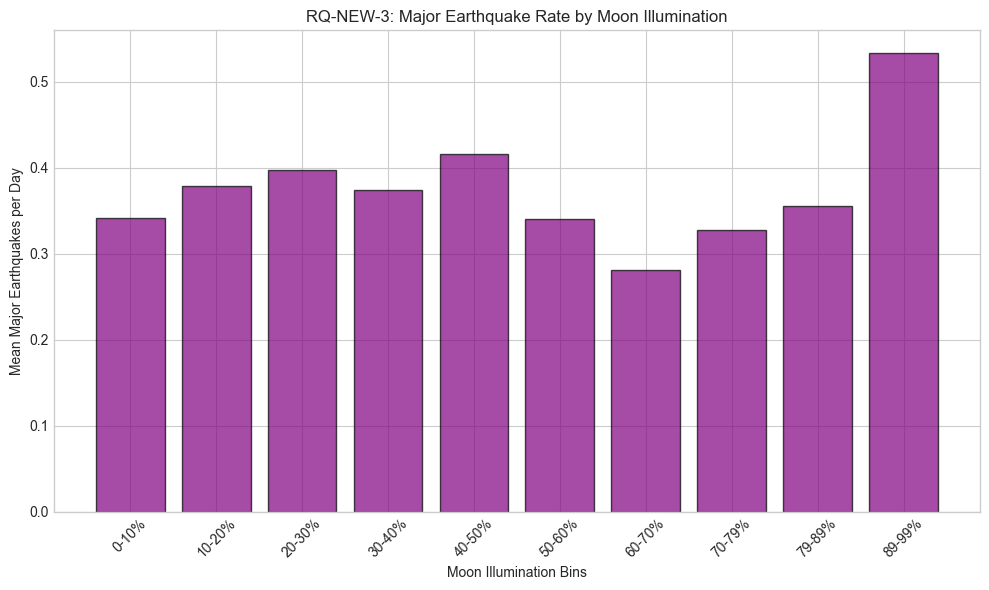

In [8]:
# Visualization for RQ-NEW-3
fig, ax = plt.subplots(figsize=(10, 6))

illum_bins = pd.cut(daily_moon['illumination'], bins=10)
bin_stats = daily_moon.groupby(illum_bins)['major_eq_count'].mean()

ax.bar(range(len(bin_stats)), bin_stats.values, color='purple', alpha=0.7, edgecolor='black')
ax.set_xlabel('Moon Illumination Bins')
ax.set_ylabel('Mean Major Earthquakes per Day')
ax.set_title('RQ-NEW-3: Major Earthquake Rate by Moon Illumination')
ax.set_xticks(range(len(bin_stats)))
ax.set_xticklabels([f'{int(b.left)}-{int(b.right)}%' for b in bin_stats.index], rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq3_moon_illumination.png'), dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()

---
## 5. RQ-NEW-4: Major Earthquakes Uniform Across Time-of-Day

**Question:** Are major earthquakes uniformly distributed across time-of-day bins?

**Test:** Chi-square Goodness-of-Fit + Standardized Residuals

In [9]:
print('='*70)
print('RQ-NEW-4: MAJOR EARTHQUAKES ACROSS TIME-OF-DAY BINS')
print('='*70)

# Create time bins
def get_time_bin(hour):
    if hour < 4: return '00-04'
    elif hour < 8: return '04-08'
    elif hour < 12: return '08-12'
    elif hour < 16: return '12-16'
    elif hour < 20: return '16-20'
    else: return '20-24'

major_eq = df[df['magnitude'] >= 4.0].copy()
major_eq['time_bin'] = major_eq['hour'].apply(get_time_bin)

time_bin_counts = major_eq['time_bin'].value_counts().sort_index()
n_bins = 6
expected = len(major_eq) / n_bins

print(f'\nTotal major earthquakes (M >= 4.0): {len(major_eq):,}')
print(f'Expected per bin (uniform): {expected:.1f}')
print(f'\nObserved counts by time-of-day:')
for bin_name, count in time_bin_counts.items():
    print(f'  {bin_name}: {count}')

# Chi-square test
chi2, p_value = stats.chisquare(time_bin_counts.values)
print(f'\nChi-square Goodness-of-Fit Test:')
print(f'  Chi² = {chi2:.4f}')
print(f'  p-value = {p_value:.4e}')

# Standardized residuals
print(f'\nStandardized Residuals (|SR| > 2 = significant):')
for bin_name, obs in time_bin_counts.items():
    sr = (obs - expected) / np.sqrt(expected)
    sig = "***" if abs(sr) > 2 else ""
    print(f'  {bin_name}: SR = {sr:+.2f} {sig}')

print('\nInterpretation:')
if p_value < 0.05:
    print('  → SIGNIFICANT: Major earthquakes NOT uniformly distributed across time-of-day')
else:
    print('  → Not significant: Major earthquakes appear uniform across time-of-day')

RQ-NEW-4: MAJOR EARTHQUAKES ACROSS TIME-OF-DAY BINS



Total major earthquakes (M >= 4.0): 4,103
Expected per bin (uniform): 683.8

Observed counts by time-of-day:
  00-04: 631
  04-08: 683
  08-12: 730
  12-16: 695
  16-20: 696
  20-24: 668

Chi-square Goodness-of-Fit Test:
  Chi² = 7.9651
  p-value = 1.5817e-01

Standardized Residuals (|SR| > 2 = significant):
  00-04: SR = -2.02 ***
  04-08: SR = -0.03 
  08-12: SR = +1.77 
  12-16: SR = +0.43 
  16-20: SR = +0.47 
  20-24: SR = -0.61 

Interpretation:
  → Not significant: Major earthquakes appear uniform across time-of-day


---
## 6. RQ-NEW-5: Major Earthquakes Uniform Across Seasons

**Question:** Are major earthquakes uniformly distributed across seasons?

**Test:** Chi-square Goodness-of-Fit + Standardized Residuals

In [10]:
print('='*70)
print('RQ-NEW-5: MAJOR EARTHQUAKES ACROSS SEASONS')
print('='*70)

# Create season mapping
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

major_eq['season'] = major_eq['month'].apply(get_season)

season_order = ['Winter', 'Spring', 'Summer', 'Fall']
season_counts = major_eq['season'].value_counts().reindex(season_order)
expected_season = len(major_eq) / 4

print(f'\nTotal major earthquakes: {len(major_eq):,}')
print(f'Expected per season (uniform): {expected_season:.1f}')
print(f'\nObserved counts by season:')
for season, count in season_counts.items():
    print(f'  {season}: {count}')

# Chi-square test
chi2_season, p_value_season = stats.chisquare(season_counts.values)
print(f'\nChi-square Goodness-of-Fit Test:')
print(f'  Chi² = {chi2_season:.4f}')
print(f'  p-value = {p_value_season:.4e}')

# Standardized residuals
print(f'\nStandardized Residuals:')
for season, obs in season_counts.items():
    sr = (obs - expected_season) / np.sqrt(expected_season)
    sig = "***" if abs(sr) > 2 else ""
    print(f'  {season}: SR = {sr:+.2f} {sig}')

print('\nInterpretation:')
if p_value_season < 0.05:
    print('  → SIGNIFICANT: Major earthquakes NOT uniformly distributed across seasons')
else:
    print('  → Not significant: Major earthquakes appear uniform across seasons')

RQ-NEW-5: MAJOR EARTHQUAKES ACROSS SEASONS

Total major earthquakes: 4,103
Expected per season (uniform): 1025.8

Observed counts by season:
  Winter: 1431
  Spring: 873
  Summer: 864
  Fall: 935

Chi-square Goodness-of-Fit Test:
  Chi² = 216.3868
  p-value = 1.2127e-46

Standardized Residuals:
  Winter: SR = +12.65 ***
  Spring: SR = -4.77 ***
  Summer: SR = -5.05 ***
  Fall: SR = -2.83 ***

Interpretation:
  → SIGNIFICANT: Major earthquakes NOT uniformly distributed across seasons


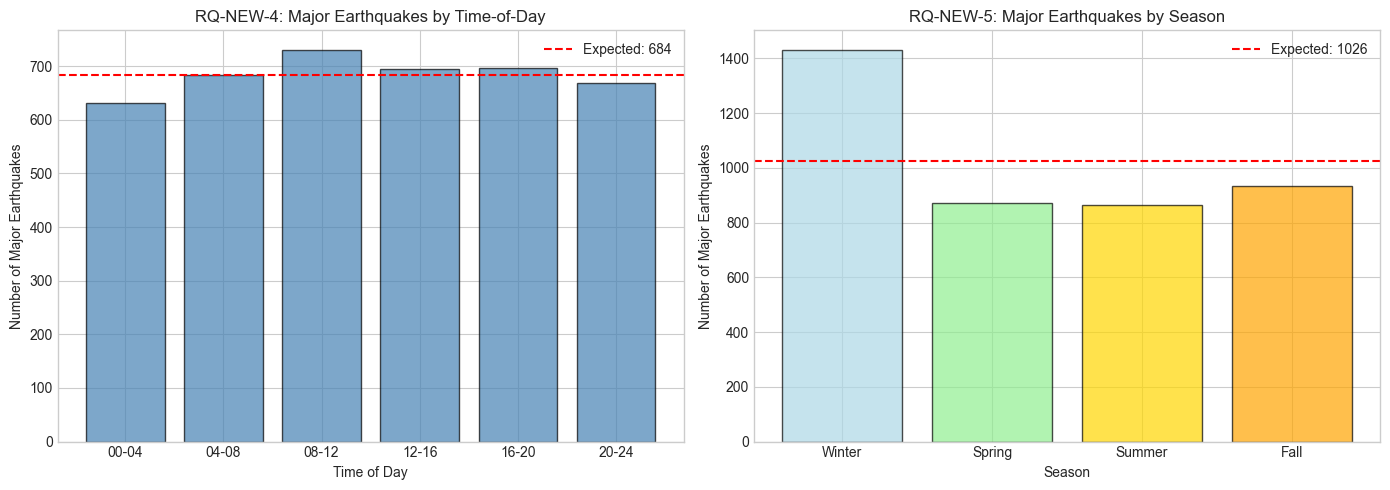

In [11]:
# Visualization for RQ-NEW-4 and RQ-NEW-5
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time-of-day
axes[0].bar(time_bin_counts.index, time_bin_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=expected, color='red', linestyle='--', label=f'Expected: {expected:.0f}')
axes[0].set_xlabel('Time of Day')
axes[0].set_ylabel('Number of Major Earthquakes')
axes[0].set_title('RQ-NEW-4: Major Earthquakes by Time-of-Day')
axes[0].legend()

# Seasonal
colors_season = ['lightblue', 'lightgreen', 'gold', 'orange']
axes[1].bar(season_counts.index, season_counts.values, color=colors_season, alpha=0.7, edgecolor='black')
axes[1].axhline(y=expected_season, color='red', linestyle='--', label=f'Expected: {expected_season:.0f}')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Number of Major Earthquakes')
axes[1].set_title('RQ-NEW-5: Major Earthquakes by Season')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'rq4_rq5_time_season.png'), dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()

---
## 7. RQ-NEW-6: Factors Predicting Earthquake Magnitude

**Question:** Which factors—depth, fault distance, geology type, tectonic setting—best predict earthquake magnitude?

**Test:** Multiple Linear Regression

In [12]:
print('='*70)
print('RQ-NEW-6: FACTORS PREDICTING EARTHQUAKE MAGNITUDE')
print('='*70)

# Prepare dataset
model_data = df[['magnitude', 'depth', 'fault_distance_km', 'geology_type', 'tectonic_setting']].dropna()
print(f'\nRecords with complete data: {len(model_data):,}')

if len(model_data) > 100:
    # Encode categorical variables
    geology_dummies = pd.get_dummies(model_data['geology_type'], prefix='geo', drop_first=True)
    tectonic_dummies = pd.get_dummies(model_data['tectonic_setting'], prefix='tect', drop_first=True)
    
    X = pd.concat([
        model_data[['depth', 'fault_distance_km']].reset_index(drop=True),
        geology_dummies.reset_index(drop=True),
        tectonic_dummies.reset_index(drop=True)
    ], axis=1).astype(float)
    X = sm.add_constant(X)
    y = model_data['magnitude'].values
    
    # Fit model
    model_full = sm.OLS(y, X).fit()
    print('\n--- Full Model Results ---')
    print(model_full.summary())
    
    # VIF check
    print('\n--- VIF Check ---')
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns[1:]
    try:
        vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])]
        print(vif_data.to_string(index=False))
    except:
        print('VIF calculation skipped')
    
    print('\n--- Interpretation ---')
    print(f'R² = {model_full.rsquared:.4f} (explains {100*model_full.rsquared:.1f}% of variance)')
    print(f'\nSignificant predictors (p < 0.05):')
    for var, coef, pval in zip(model_full.params.index, model_full.params.values, model_full.pvalues.values):
        if pval < 0.05 and var != 'const':
            direction = "increases" if coef > 0 else "decreases"
            print(f'  {var}: β={coef:.4f} → {direction} magnitude')
else:
    print('Insufficient data')

RQ-NEW-6: FACTORS PREDICTING EARTHQUAKE MAGNITUDE

Records with complete data: 3,907

--- Full Model Results ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.289
Date:                Fri, 16 Jan 2026   Prob (F-statistic):           0.000953
Time:                        00:08:01   Log-Likelihood:                -1933.2
No. Observations:                3907   AIC:                             3884.
Df Residuals:                    3898   BIC:                             3941.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---

                 Variable      VIF
                    depth 1.087147
        fault_distance_km 1.250208
   geo_Limestone/alluvium      inf
 geo_Metamorphic/volcanic      inf
   geo_Sedimentary basins      inf
geo_Sedimentary/limestone      inf
 geo_Volcanic/metamorphic      inf
     geo_Volcanic/plateau      inf
          tect_Active NAF      inf
    tect_Active collision      inf
    tect_Active extension      inf
                 tect_Low      inf
            tect_Moderate      inf
              tect_Stable      inf

--- Interpretation ---
R² = 0.0067 (explains 0.7% of variance)

Significant predictors (p < 0.05):
  depth: β=0.0027 → increases magnitude
  geo_Limestone/alluvium: β=0.3895 → increases magnitude
  geo_Metamorphic/volcanic: β=0.3886 → increases magnitude
  geo_Sedimentary basins: β=0.3942 → increases magnitude
  geo_Sedimentary/limestone: β=0.7975 → increases magnitude
  geo_Volcanic/metamorphic: β=0.4037 → increases magnitude
  geo_Volcanic/plateau: β=0.3904 → increase

---
## 8. RQ-NEW-7: Near-Fault Lunar/Pressure Effect on Magnitude

**Question:** Among earthquakes within 50km of active fault, do lunar phase or atmospheric pressure explain magnitude variation after controlling for depth?

**Test:** Multiple Linear Regression (subset analysis)

In [13]:
print('='*70)
print('RQ-NEW-7: NEAR-FAULT LUNAR/PRESSURE EFFECT ON MAGNITUDE')
print('='*70)

# Filter to earthquakes within 50km of fault
near_fault = df[df['fault_distance_km'] <= 50].copy()
print(f'\nEarthquakes within 50km of fault: {len(near_fault):,}')

model_data = near_fault[['magnitude', 'depth', 'moon_phase', 'pressure_hpa']].dropna()
print(f'Records with complete data: {len(model_data):,}')

if len(model_data) > 100:
    # Encode moon phase
    moon_dummies = pd.get_dummies(model_data['moon_phase'], prefix='moon', drop_first=True)
    
    X = pd.concat([
        model_data[['depth', 'pressure_hpa']].reset_index(drop=True).astype(float),
        moon_dummies.reset_index(drop=True).astype(float)
    ], axis=1)
    X = sm.add_constant(X)
    y = model_data['magnitude'].values
    
    model_near = sm.OLS(y, X).fit()
    print('\n--- Near-Fault Model Results ---')
    print(model_near.summary())
    
    print('\n--- Interpretation ---')
    print(f'R² = {model_near.rsquared:.4f}')
    print(f'\nAmong near-fault earthquakes:')
    
    sig_found = False
    for var, coef, pval in zip(model_near.params.index, model_near.params.values, model_near.pvalues.values):
        if pval < 0.05 and var != 'const':
            direction = "increases" if coef > 0 else "decreases"
            print(f'  {var}: β={coef:.4f} → {direction} magnitude')
            sig_found = True
    
    if not sig_found:
        print('  No moon phase or pressure variables significantly predict magnitude')
else:
    print('Insufficient near-fault data')

RQ-NEW-7: NEAR-FAULT LUNAR/PRESSURE EFFECT ON MAGNITUDE

Earthquakes within 50km of fault: 1,329
Records with complete data: 1,329

--- Near-Fault Model Results ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.452
Date:                Fri, 16 Jan 2026   Prob (F-statistic):            0.00419
Time:                        00:08:01   Log-Likelihood:                -740.47
No. Observations:                1329   AIC:                             1493.
Df Residuals:                    1323   BIC:                             1524.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          

---
## 9. RQ-NEW-8: High Population + Soft Soil + High Risk Overlap

**Question:** Do highly populated areas with soft soils coincide with zones of high seismic hazard AND high liquefaction risk?

**Test:** Logistic Regression with VIF check

In [14]:
print('='*70)
print('RQ-NEW-8: HIGH POPULATION + SOFT SOIL + HIGH RISK OVERLAP')
print('='*70)

# Define high risk
high_hazard = df['seismic_hazard'].isin(['Very High', 'High'])
high_liquefaction = df['liquefaction_risk'].isin(['Very High', 'High'])
df['high_risk'] = (high_hazard & high_liquefaction).astype(int)

print(f'\nHigh Risk Definition:')
print(f'  Seismic hazard in (Very High, High) AND Liquefaction risk in (Very High, High)')
print(f'\nHigh risk events: {df["high_risk"].sum():,} ({100*df["high_risk"].mean():.1f}%)')

# Prepare analysis dataset
analysis_df = df[['high_risk', 'population_density', 'vs30', 'soil_class']].dropna().copy()
print(f'Records with complete data: {len(analysis_df):,}')

# Create population density bins
analysis_df['pop_bin'] = pd.cut(analysis_df['population_density'],
                                bins=[0, 50, 100, 200, 500, np.inf],
                                labels=['<50', '50-100', '100-200', '200-500', '>500'])

# Prepare predictors
pop_dummies = pd.get_dummies(analysis_df['pop_bin'], prefix='pop', drop_first=True).astype(float)
X = pd.concat([pop_dummies.reset_index(drop=True), 
               analysis_df[['vs30']].reset_index(drop=True).astype(float)], axis=1)
X = sm.add_constant(X)
y = analysis_df['high_risk'].values.astype(float)

# VIF check
print('\n--- VIF Check ---')
try:
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data.to_string(index=False))
except Exception as e:
    print(f'VIF error: {e}')

# Fit logistic regression
print('\n--- Logistic Regression ---')
try:
    logit_model = sm.Logit(y, X).fit(disp=0, maxiter=100)
    
    # Odds ratios
    print('\n--- Odds Ratios ---')
    odds_ratios = np.exp(logit_model.params)
    ci = logit_model.conf_int()
    ci_odds = np.exp(ci)
    
    or_df = pd.DataFrame({
        'Variable': X.columns,
        'Odds Ratio': odds_ratios.values,
        'p-value': logit_model.pvalues.values,
        '95% CI Lower': ci_odds[0].values,
        '95% CI Upper': ci_odds[1].values
    })
    print(or_df.to_string(index=False))
    
    print('\nInterpretation:')
    for _, row in or_df.iterrows():
        if row['p-value'] < 0.05 and row['Variable'] != 'const':
            direction = "INCREASES" if row['Odds Ratio'] > 1 else "DECREASES"
            print(f'  {row["Variable"]}: OR={row["Odds Ratio"]:.2f} → {direction} high risk odds')
except Exception as e:
    print(f'Model error: {e}')

RQ-NEW-8: HIGH POPULATION + SOFT SOIL + HIGH RISK OVERLAP

High Risk Definition:
  Seismic hazard in (Very High, High) AND Liquefaction risk in (Very High, High)

High risk events: 90,648 (17.3%)
Records with complete data: 514,965

--- VIF Check ---


   Variable       VIF
      const 27.416138
 pop_50-100  2.015362
pop_100-200  1.945465
pop_200-500  2.130865
   pop_>500  1.079388
       vs30  1.539623

--- Logistic Regression ---



--- Odds Ratios ---
   Variable   Odds Ratio       p-value  95% CI Lower  95% CI Upper
      const 1.836041e+14  0.000000e+00  1.155814e+14  2.916600e+14
 pop_50-100 2.734101e+00  1.389714e-13  2.094488e+00  3.569039e+00
pop_100-200 1.804772e+01 2.014823e-102  1.386186e+01  2.349757e+01
pop_200-500 3.202180e-04  0.000000e+00  2.431816e-04  4.216585e-04
   pop_>500 6.993124e+05  9.981057e-01  0.000000e+00           inf
       vs30 8.692289e-01  0.000000e+00  8.677457e-01  8.707146e-01

Interpretation:
  pop_50-100: OR=2.73 → INCREASES high risk odds
  pop_100-200: OR=18.05 → INCREASES high risk odds
  pop_200-500: OR=0.00 → DECREASES high risk odds
  vs30: OR=0.87 → DECREASES high risk odds


---
## 10. Summary of All New Research Questions

In [15]:
# Create summary table
print('='*70)
print('SUMMARY OF NEW RESEARCH QUESTIONS')
print('='*70)

summary_results = [
    ['RQ-NEW-1', 'Eclipse vs Non-Eclipse Rate', 'Fisher\'s Exact Test', f'p={fisher_pvalue:.4f}', 'Yes' if fisher_pvalue < 0.05 else 'No'],
    ['RQ-NEW-2', 'Eclipse Magnitude Effect', 'Poisson/NB Regression', 'See above', '-'],
    ['RQ-NEW-3', 'Moon Illumination Effect', 'Poisson Regression', f'p={model_linear.pvalues[1]:.4f}' if aic_linear != np.inf else 'N/A', 'Yes' if aic_linear != np.inf and model_linear.pvalues[1] < 0.05 else 'No'],
    ['RQ-NEW-4', 'Time-of-Day Uniformity', 'Chi-square + SR', f'p={p_value:.4e}', 'Yes' if p_value < 0.05 else 'No'],
    ['RQ-NEW-5', 'Seasonal Uniformity', 'Chi-square + SR', f'p={p_value_season:.4e}', 'Yes' if p_value_season < 0.05 else 'No'],
    ['RQ-NEW-6', 'Magnitude Predictors', 'Multiple Regression', f'R²={model_full.rsquared:.4f}' if 'model_full' in dir() else 'N/A', '-'],
    ['RQ-NEW-7', 'Near-Fault Effects', 'Multiple Regression', f'R²={model_near.rsquared:.4f}' if 'model_near' in dir() else 'N/A', '-'],
    ['RQ-NEW-8', 'High Risk Overlap', 'Logistic + VIF', 'See above', '-']
]

summary_df = pd.DataFrame(summary_results, columns=['RQ', 'Question', 'Test', 'Result', 'Significant'])
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(os.path.join(TABLES_PATH, 'new_rqs_summary.csv'), index=False)
print(f'\nSummary saved to: {os.path.join(TABLES_PATH, "new_rqs_summary.csv")}')

SUMMARY OF NEW RESEARCH QUESTIONS
      RQ                    Question                  Test       Result Significant
RQ-NEW-1 Eclipse vs Non-Eclipse Rate   Fisher's Exact Test     p=0.4484          No
RQ-NEW-2    Eclipse Magnitude Effect Poisson/NB Regression    See above           -
RQ-NEW-3    Moon Illumination Effect    Poisson Regression     p=0.0000         Yes
RQ-NEW-4      Time-of-Day Uniformity       Chi-square + SR p=1.5817e-01          No
RQ-NEW-5         Seasonal Uniformity       Chi-square + SR p=1.2127e-46         Yes
RQ-NEW-6        Magnitude Predictors   Multiple Regression    R²=0.0067           -
RQ-NEW-7          Near-Fault Effects   Multiple Regression    R²=0.0129           -
RQ-NEW-8           High Risk Overlap        Logistic + VIF    See above           -

Summary saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/new_rqs_summary.csv


In [16]:
print('\n' + '='*70)
print('NEW RESEARCH QUESTIONS ANALYSIS COMPLETE')
print('='*70)
print(f'\nFigures saved to: {OUTPUT_DIR}')
print(f'Tables saved to: {TABLES_PATH}')


NEW RESEARCH QUESTIONS ANALYSIS COMPLETE

Figures saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/17_new_rqs
Tables saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables
